In [43]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from math import sqrt, exp, log
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8')
sns.set_palette("Set2")


# Лабораторная работа №4: Бинарная классификация

## Загрузка данных


In [44]:
dataset = pd.read_csv('../datasets/famcs_students.csv')
print(f"Размер датасета: {dataset.shape}")
print(f"\nСтолбцы: {dataset.columns.tolist()}")

print("\n" + "="*85)
print("ПРОВЕРКА НА ПРОПУЩЕННЫЕ ЗНАЧЕНИЯ")
print("="*85)
missing = dataset.isnull().sum()
missing_percent = (dataset.isnull().sum() / len(dataset)) * 100
missing_df = pd.DataFrame({
    'Пропусков': missing,
    'Процент': missing_percent
})
if missing_df['Пропусков'].sum() > 0:
    print(missing_df[missing_df['Пропусков'] > 0])
else:
    print("Пропущенных значений нет!")

dataset.head()


Размер датасета: (127, 25)

Столбцы: ['cource', 'group', 'stream', 'sex', 'age', 'ss', 'interest', 'os', 'weekend_study', 'bad_sleep', 'glasses', 'work_experience', 'ai', 'height', 'anime', 'social', 'sport', 'miss', 'study_form', 'foot_size', 'eye_color', 'score', 'retake', 'hostel', 'literature']

ПРОВЕРКА НА ПРОПУЩЕННЫЕ ЗНАЧЕНИЯ
Пропущенных значений нет!


,cource,group,stream,sex,age,ss,interest,os,weekend_study,bad_sleep,glasses,work_experience,ai,height,anime,social,sport,miss,study_form,foot_size,eye_color,score,retake,hostel,literature
0,4,11,Прикладная информатика,М,20.0,Нет,Математика,MacOS,Да,Да,Нет,Меньше года,Cursor,192.0,Нет,Экстраверт,"Редко, легкая физкультура",3.0,Бюджет,48.0,Карие,9.2,0,"Нет, я из Минска",Да
1,4,11,Прикладная информатика,Ж,20.0,Нет,Программирование,MacOS,Нет,Нет,Нет,1-2 года,Mistral,169.0,Нет,Экстраверт,"Да, я спортсмен",5.0,Бюджет,39.0,Зеленые,8.8,0,"Нет, я из Минска",Да
2,4,11,Прикладная информатика,Ж,19.0,Нет,Программирование,MacOS,Да,Нет,Нет,Меньше года,ChatGPT,190.0,Нет,Экстраверт,Вообще нет,10.0,Бюджет,41.0,Карие,8.8,0,"Нет, я из Минска",Да
3,4,11,Прикладная информатика,Ж,20.0,Нет,Математика,MacOS,Да,Да,Нет,1-2 года,Qwen,158.0,Нет,Экстраверт,"Да, я спортсмен",3.0,Бюджет,36.0,Карие,8.8,0,"Нет, я из Минска",Да
4,4,11,Прикладная информатика,М,20.0,Нет,Математика,Windows,Да,Нет,Нет,Не работаю,DeepSeek,187.0,Нет,Интроверт,Вообще нет,1.0,Бюджет,46.0,Зеленые,9.0,0,"Нет, я из Минска",Да


In [45]:
N = 21
binary_cols = ['ss', 'interest', 'weekend_study', 'bad_sleep', 'glasses', 'anime', 'study_form', 'literature']
target_col_idx = N % 8
target_col = binary_cols[target_col_idx]

print(f"N = {N}")
print(f"Индекс целевой переменной: {target_col_idx}")
print(f"Целевая переменная: {target_col}")

print(f"\nУникальные значения в '{target_col}': {dataset[target_col].unique()}")
print(f"Распределение:\n{dataset[target_col].value_counts()}")


N = 21
Индекс целевой переменной: 5
Целевая переменная: anime

Уникальные значения в 'anime': ['Нет' 'Да']
Распределение:
anime
Нет    73
Да     54
Name: count, dtype: int64


## Разделение данных на выборки


In [46]:
all_cols = dataset.columns.tolist()

selected_features = [col for col in all_cols if col != target_col]

print("="*85)
print("ВЫБОР ПРИЗНАКОВ ДЛЯ X")
print("="*85)
print(f"Исключаем целевую переменную: {target_col}")
print(f"\nВыбранные признаки ({len(selected_features)}): {selected_features}")

features_df = dataset[selected_features].copy()
print(f"\nРазмер X: {features_df.shape}")
print(f"\nИнформация о признаках:")
print(features_df.info())


ВЫБОР ПРИЗНАКОВ ДЛЯ X
Исключаем целевую переменную: anime

Выбранные признаки (24): ['cource', 'group', 'stream', 'sex', 'age', 'ss', 'interest', 'os', 'weekend_study', 'bad_sleep', 'glasses', 'work_experience', 'ai', 'height', 'social', 'sport', 'miss', 'study_form', 'foot_size', 'eye_color', 'score', 'retake', 'hostel', 'literature']

Размер X: (127, 24)

Информация о признаках:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127 entries, 0 to 126
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   cource           127 non-null    int64  
 1   group            127 non-null    int64  
 2   stream           127 non-null    object 
 3   sex              127 non-null    object 
 4   age              127 non-null    float64
 5   ss               127 non-null    object 
 6   interest         127 non-null    object 
 7   os               127 non-null    object 
 8   weekend_study    127 non-null    object 
 9   

In [47]:
force_categorical = ['cource', 'group']

categorical_features = []
numeric_features = []

for col in selected_features:
    if col in force_categorical:
        categorical_features.append(col)
    elif features_df[col].dtype == 'object' or features_df[col].dtype.name == 'category':
        categorical_features.append(col)
    else:
        numeric_features.append(col)

print("="*85)
print("КЛАССИФИКАЦИЯ ПРИЗНАКОВ")
print("="*85)
print(f"\nЧисловые признаки ({len(numeric_features)}): {numeric_features}")
print(f"\nКатегориальные признаки ({len(categorical_features)}): {categorical_features}")

print("\n" + "="*85)
print("УНИКАЛЬНЫЕ ЗНАЧЕНИЯ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ")
print("="*85)
for col in categorical_features:
    unique_vals = features_df[col].unique()
    print(f"\n{col}:")
    print(f"  Количество уникальных значений: {len(unique_vals)}")
    print(f"  Уникальные значения: {unique_vals}")
    print(f"  Распределение:")
    print(features_df[col].value_counts().to_string())


КЛАССИФИКАЦИЯ ПРИЗНАКОВ

Числовые признаки (5): ['age', 'height', 'miss', 'foot_size', 'score']

Категориальные признаки (19): ['cource', 'group', 'stream', 'sex', 'ss', 'interest', 'os', 'weekend_study', 'bad_sleep', 'glasses', 'work_experience', 'ai', 'social', 'sport', 'study_form', 'eye_color', 'retake', 'hostel', 'literature']

УНИКАЛЬНЫЕ ЗНАЧЕНИЯ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ

cource:
  Количество уникальных значений: 2
  Уникальные значения: [4 3]
  Распределение:
cource
4    121
3      6

group:
  Количество уникальных значений: 8
  Уникальные значения: [11  8 13  2  3  4 12  1]
  Распределение:
group
11    24
3     23
4     18
2     17
1     17
12    13
13     9
8      6

stream:
  Количество уникальных значений: 3
  Уникальные значения: ['Прикладная информатика' 'Прикладная математика' 'Информатика']
  Распределение:
stream
Информатика               75
Прикладная информатика    46
Прикладная математика      6

sex:
  Количество уникальных значений: 2
  Уникальные значения: ['М' 'Ж

In [48]:
for col in categorical_features:
    if col in features_df.columns:
        features_df[col] = features_df[col].replace('claude', 'Claude')
        features_df[col] = features_df[col].replace('Gemini от Google', 'Gemini')

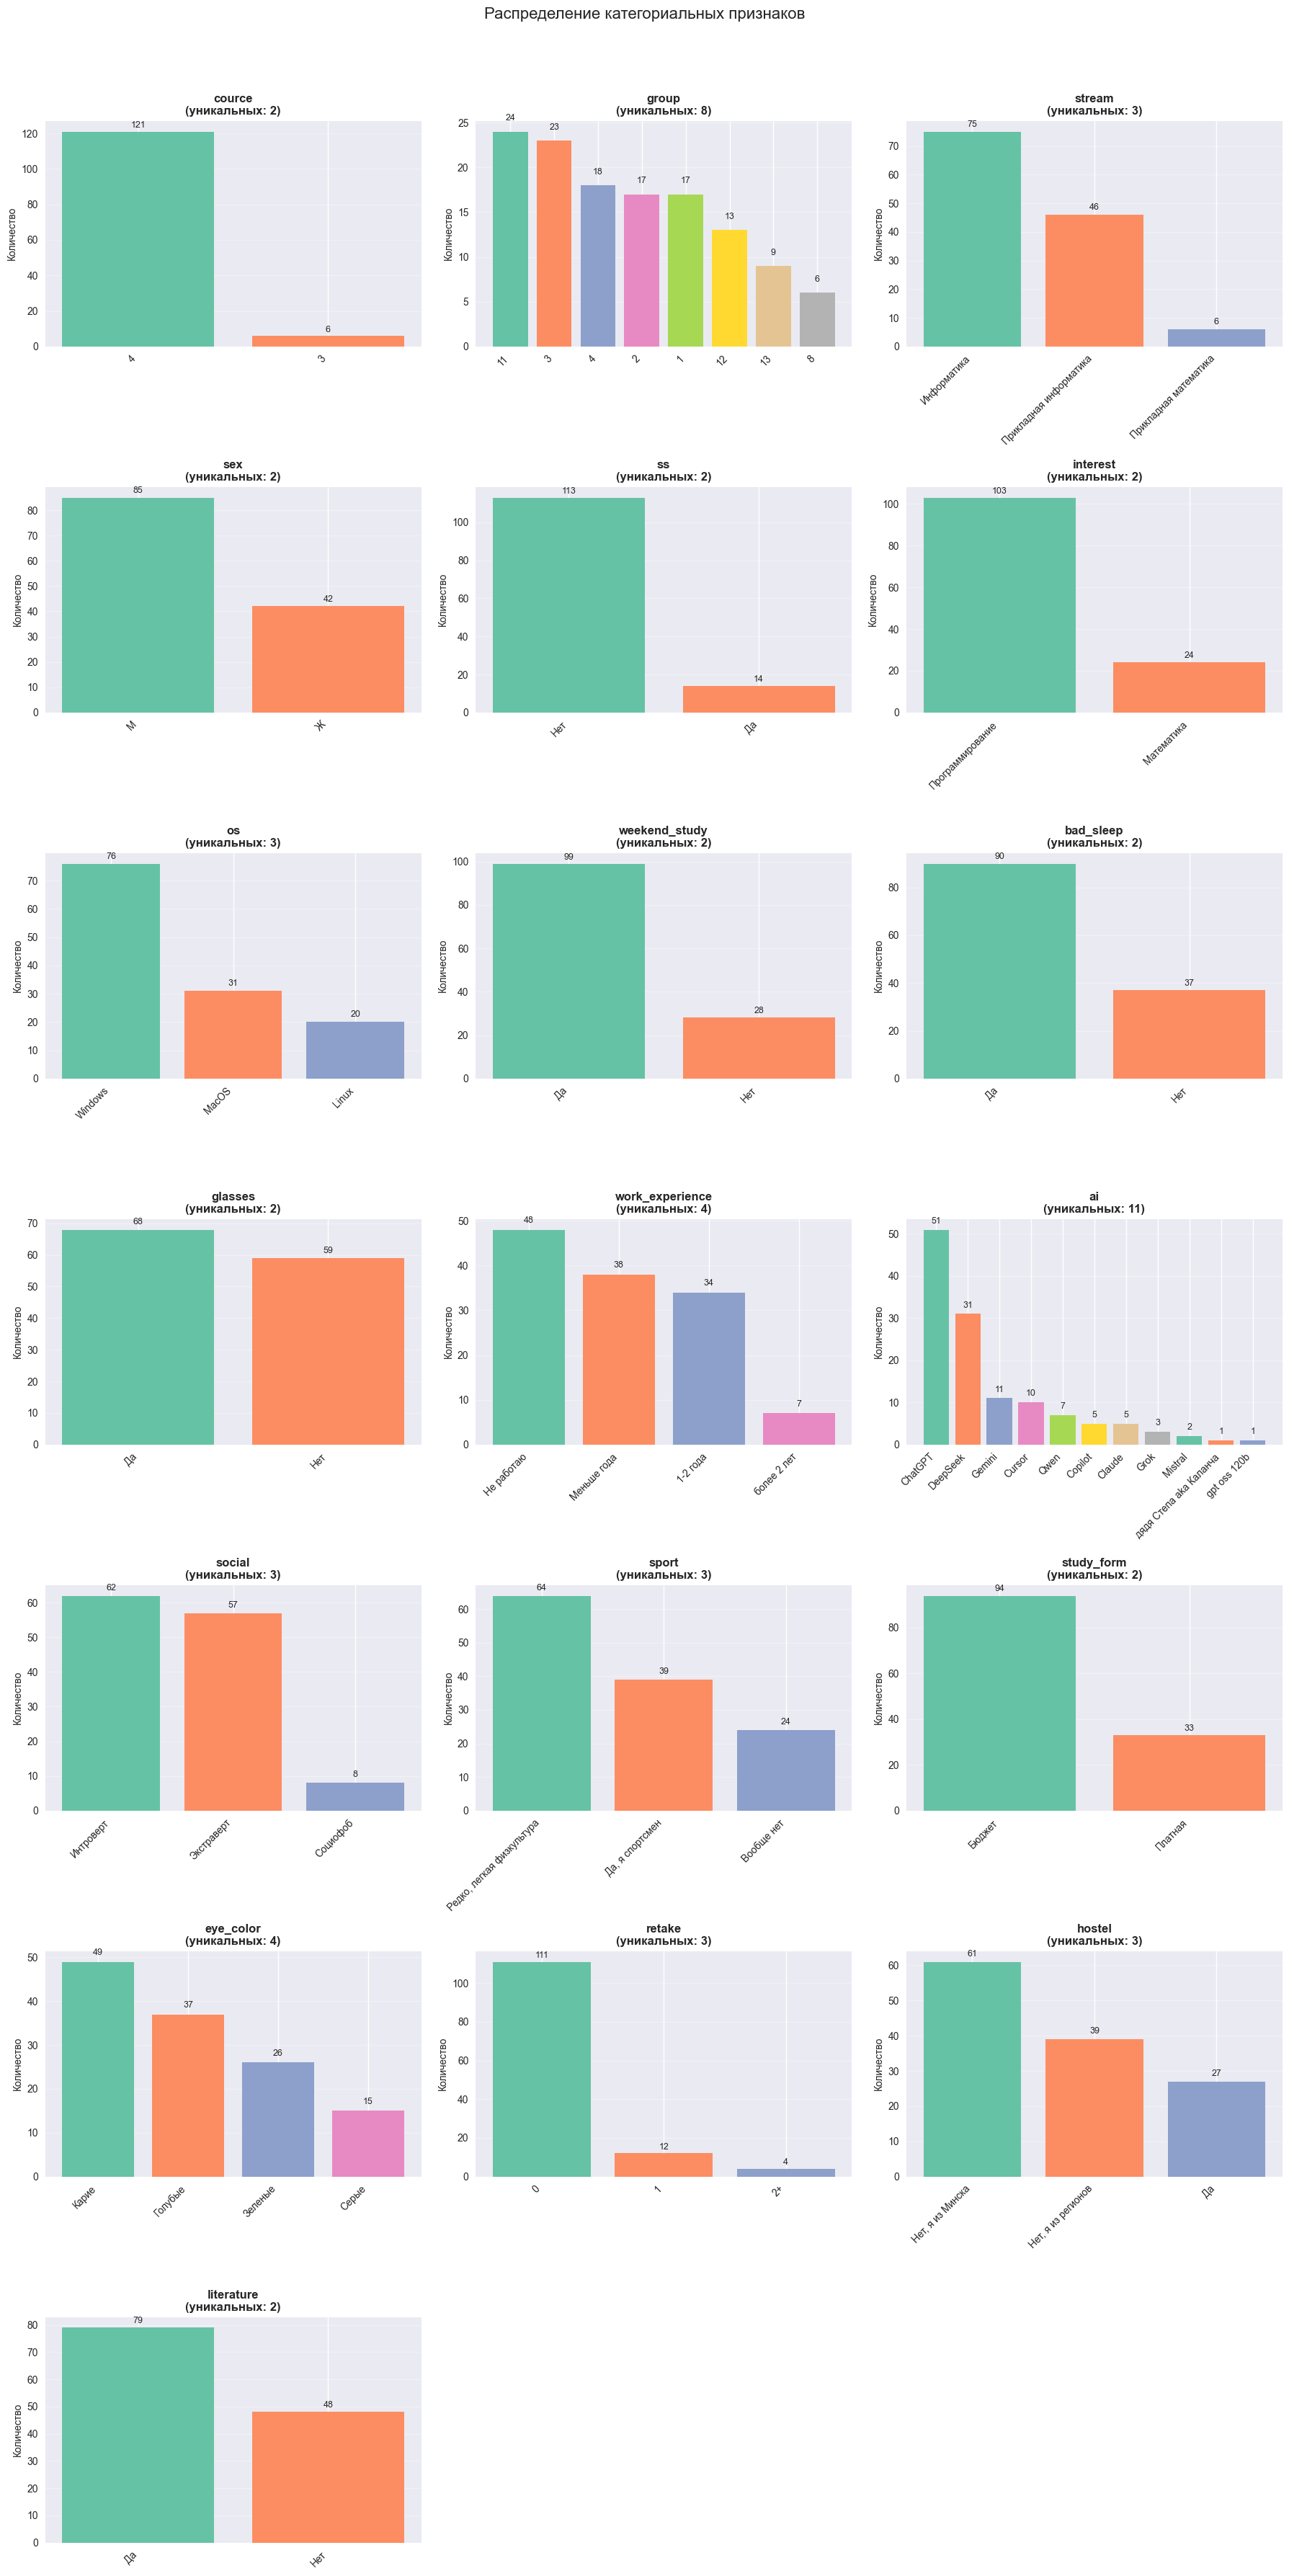

In [49]:
n_cat = len(categorical_features)
if n_cat > 0:
    fig, axes = plt.subplots((n_cat + 2) // 3, 3, figsize=(18, 5 * ((n_cat + 2) // 3)))
    if n_cat == 1:
        axes = [axes]
    else:
        axes = axes.flatten()
    
    for idx, col in enumerate(categorical_features):
        value_counts = features_df[col].value_counts()
        axes[idx].bar(range(len(value_counts)), value_counts.values, color=sns.color_palette("Set2", len(value_counts)))
        axes[idx].set_xticks(range(len(value_counts)))
        axes[idx].set_xticklabels(value_counts.index, rotation=45, ha='right')
        axes[idx].set_title(f'{col}\n(уникальных: {len(value_counts)})', fontsize=12, fontweight='bold')
        axes[idx].set_ylabel('Количество', fontsize=10)
        axes[idx].grid(True, alpha=0.3, axis='y')
        
        for i, v in enumerate(value_counts.values):
            axes[idx].text(i, v + 1, str(v), ha='center', va='bottom', fontsize=9)
    
    for idx in range(n_cat, len(axes)):
        axes[idx].axis('off')
    
    plt.suptitle('Распределение категориальных признаков', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()
else:
    print("Категориальных признаков нет")


In [50]:
if len(numeric_features) > 0:
    print("="*85)
    print("СТАТИСТИКА ПО ЧИСЛОВЫМ ПРИЗНАКАМ")
    print("="*85)
    print(features_df[numeric_features].describe())
    
    print("\n" + "="*85)
    print("ПРОПУЩЕННЫЕ ЗНАЧЕНИЯ")
    print("="*85)
    missing = features_df.isnull().sum()
    missing_percent = (features_df.isnull().sum() / len(features_df)) * 100
    missing_df = pd.DataFrame({
        'Пропусков': missing,
        'Процент': missing_percent
    })
    print(missing_df[missing_df['Пропусков'] > 0] if missing_df['Пропусков'].sum() > 0 else "Пропущенных значений нет!")


СТАТИСТИКА ПО ЧИСЛОВЫМ ПРИЗНАКАМ
              age      height        miss   foot_size       score
count  127.000000  127.000000  127.000000  127.000000  127.000000
mean    20.433071  178.751969    7.850394   41.953741    7.555433
std      1.394949   13.360222    8.716276    3.389107    1.460913
min     16.000000  100.000000    0.000000   34.125120    0.000000
25%     20.000000  170.000000    3.000000   39.000000    7.000000
50%     20.000000  179.000000    5.000000   42.000000    7.600000
75%     21.000000  187.000000   10.000000   45.000000    8.450000
max     30.000000  220.000000   40.000000   50.000000   10.000000

ПРОПУЩЕННЫЕ ЗНАЧЕНИЯ
Пропущенных значений нет!


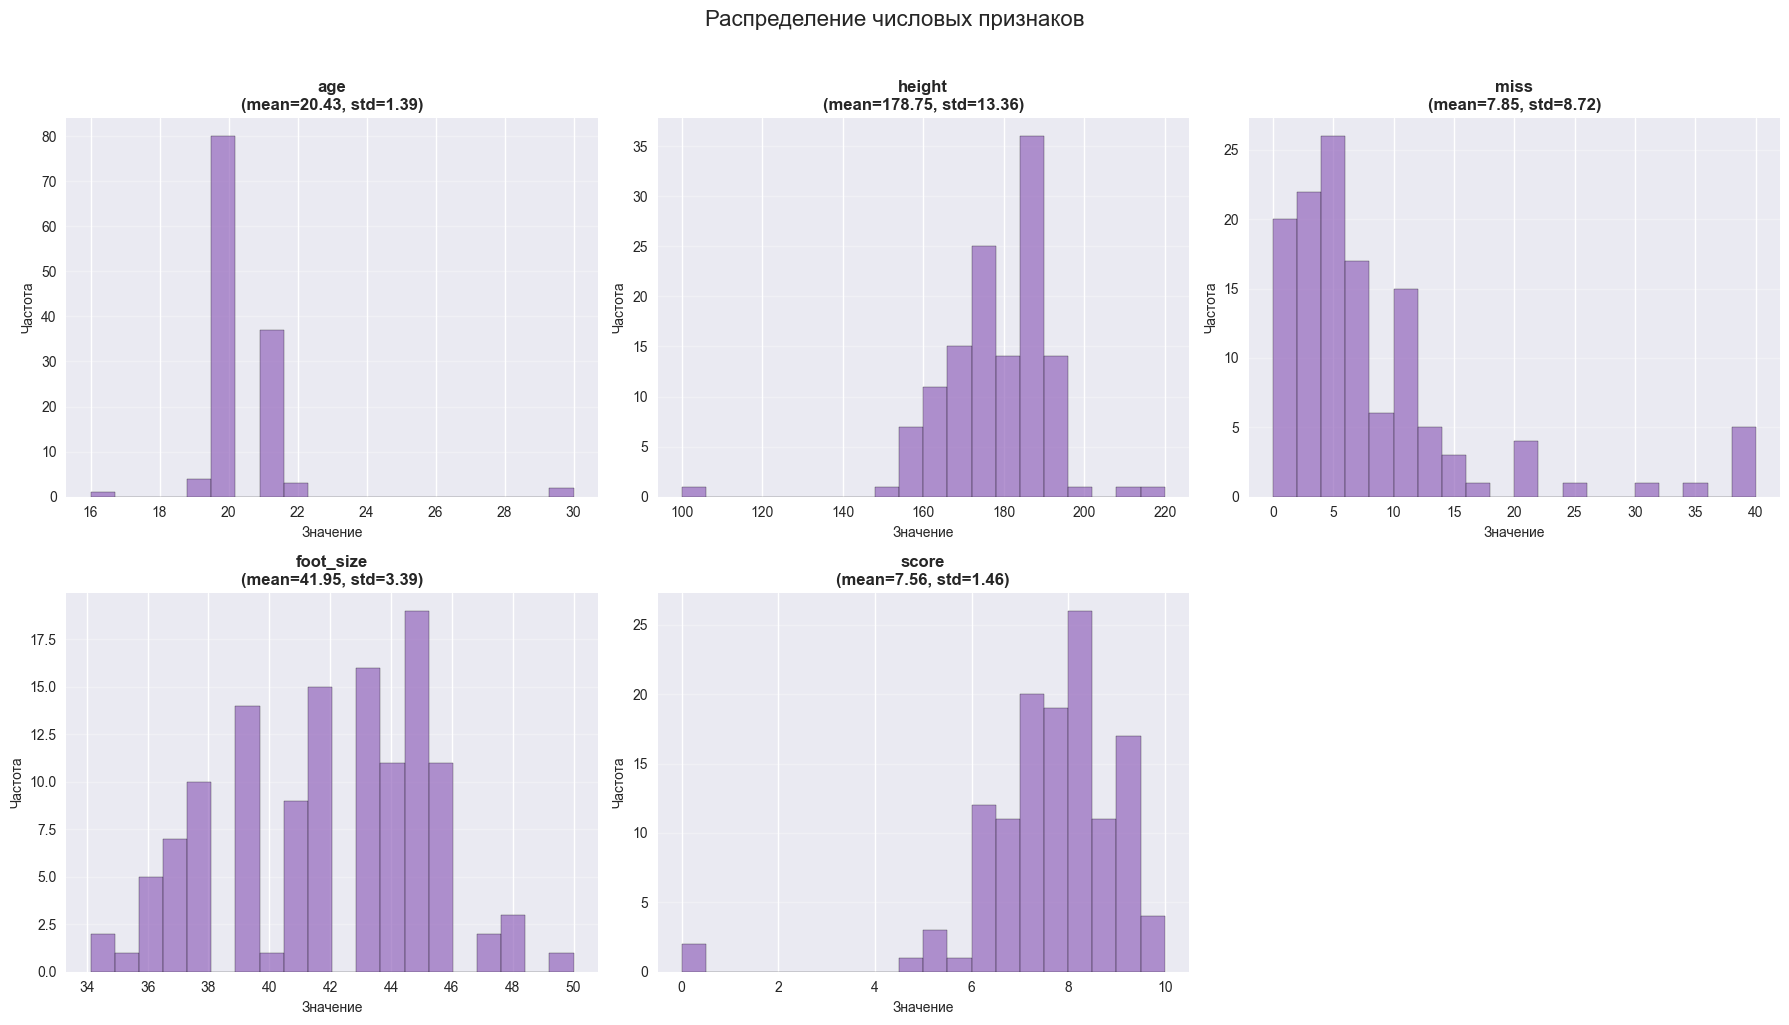

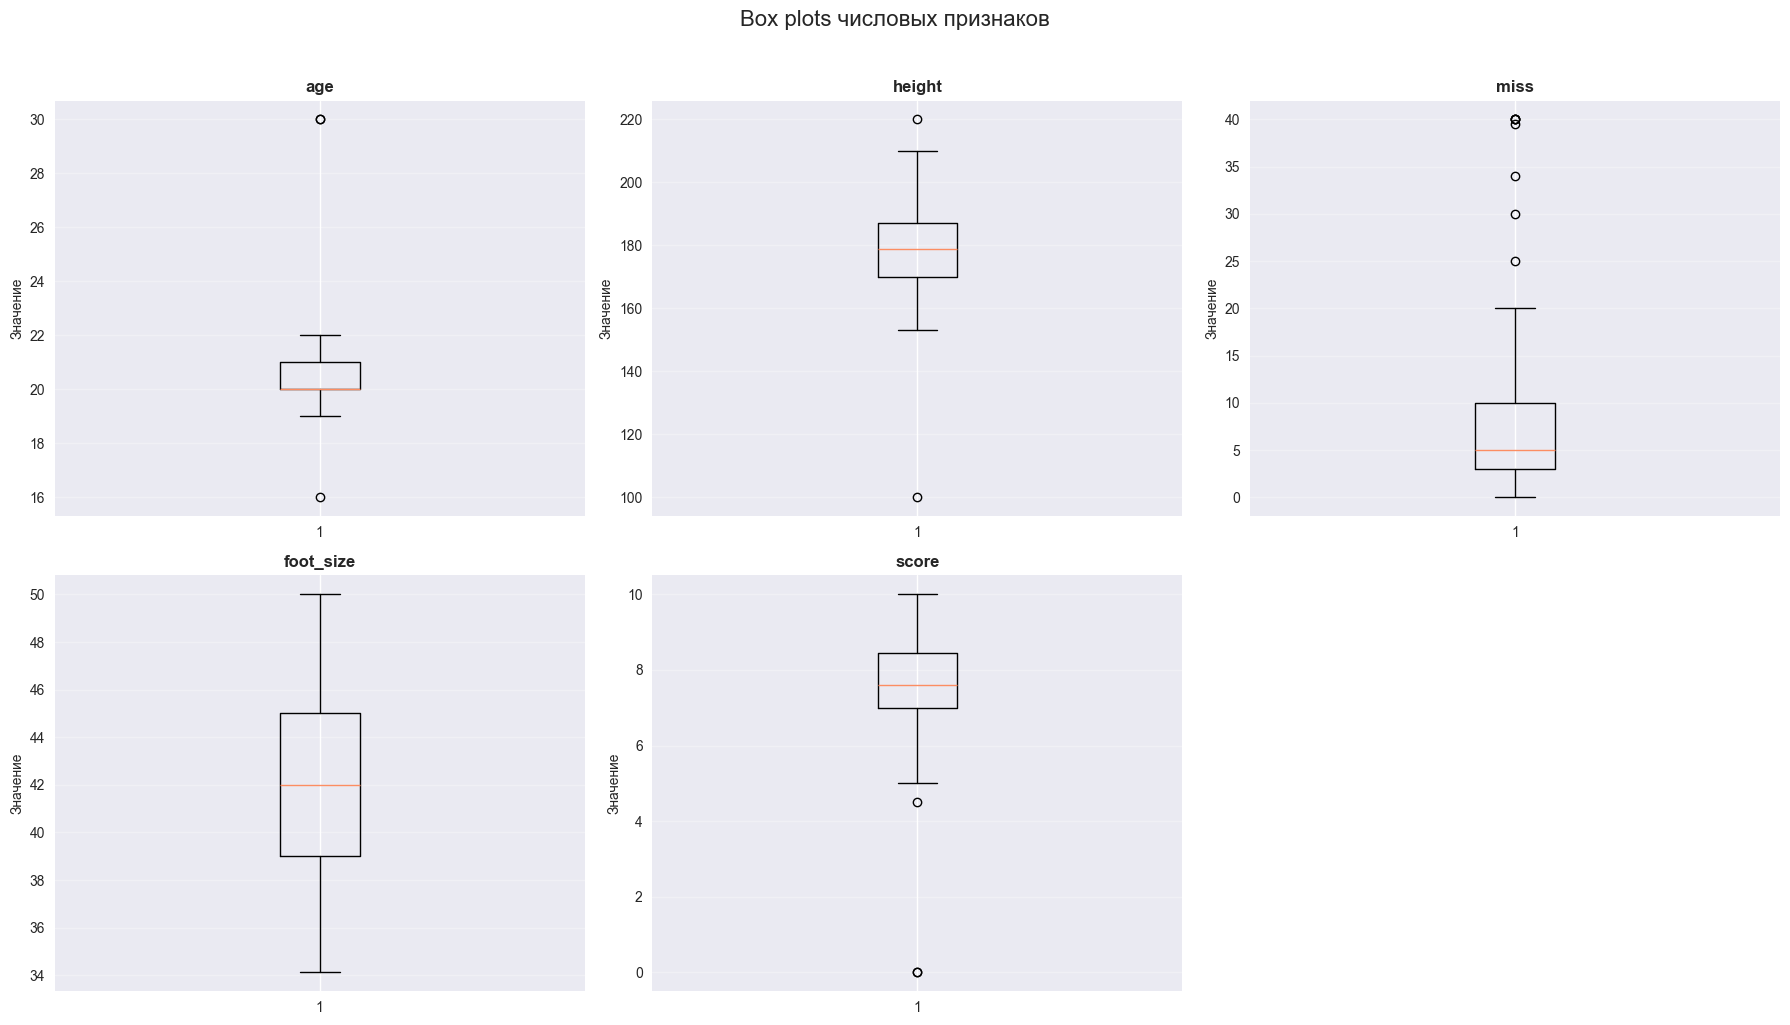

In [51]:
n_num = len(numeric_features)
if n_num > 0:
    fig, axes = plt.subplots((n_num + 2) // 3, 3, figsize=(18, 5 * ((n_num + 2) // 3)))
    if n_num == 1:
        axes = [axes]
    else:
        axes = axes.flatten()
    
    for idx, col in enumerate(numeric_features):
        axes[idx].hist(features_df[col].dropna(), bins=20, color='#9467bd', edgecolor='black', alpha=0.7)
        axes[idx].set_title(f'{col}\n(mean={features_df[col].mean():.2f}, std={features_df[col].std():.2f})', 
                           fontsize=12, fontweight='bold')
        axes[idx].set_xlabel('Значение', fontsize=10)
        axes[idx].set_ylabel('Частота', fontsize=10)
        axes[idx].grid(True, alpha=0.3, axis='y')
    
    for idx in range(n_num, len(axes)):
        axes[idx].axis('off')
    
    plt.suptitle('Распределение числовых признаков', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()
    
    fig, axes = plt.subplots((n_num + 2) // 3, 3, figsize=(18, 5 * ((n_num + 2) // 3)))
    if n_num == 1:
        axes = [axes]
    else:
        axes = axes.flatten()
    
    for idx, col in enumerate(numeric_features):
        axes[idx].boxplot(features_df[col].dropna(), vert=True)
        axes[idx].set_title(f'{col}', fontsize=12, fontweight='bold')
        axes[idx].set_ylabel('Значение', fontsize=10)
        axes[idx].grid(True, alpha=0.3, axis='y')
    
    for idx in range(n_num, len(axes)):
        axes[idx].axis('off')
    
    plt.suptitle('Box plots числовых признаков', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()
else:
    print("Числовых признаков нет")


## Frequency Encoder для категориальных признаков

Frequency Encoder заменяет категориальные значения на частоты их появления в данных (нормализованные частоты от 0 до 1). 

**Преимущества:**
- **Сокращение размерности**: вместо N бинарных признаков для N категорий получается 1 числовой признак
- **Сохранение информации о частоте**: модель видит, насколько часто встречается категория
- **Работа с редкими категориями**: редкие категории получают низкие значения, частые - высокие
- **Меньше признаков**: особенно полезно при большом количестве категорий



In [52]:
class FrequencyEncoder:
    
    def __init__(self):
        self.frequency_maps = {}
        self.feature_names = []
    
    def fit(self, X):
        self.feature_names = X.columns.tolist()
        
        for col in self.feature_names:
            value_counts = X[col].value_counts(normalize=True)
            self.frequency_maps[col] = value_counts.to_dict()
        
        return self
    
    def transform(self, X):
        if list(X.columns) != self.feature_names:
            raise ValueError("Столбцы в transform не совпадают с обученными")
        
        X_transformed = X.copy()
        
        for col in self.feature_names:
            X_transformed[col] = X_transformed[col].map(self.frequency_maps[col])
            X_transformed[col] = X_transformed[col].fillna(0.0)
        
        return X_transformed


## Подготовка данных для обучения


In [64]:
print(f"Размер данных до удаления выбросов: {dataset.shape[0]}")
if 'miss' in dataset.columns:
    outliers_mask = dataset['miss'] > 20
    n_outliers = outliers_mask.sum()
    if n_outliers > 0:
        print(f"Найдено выбросов (miss > 20): {n_outliers}")
        dataset = dataset[~outliers_mask].reset_index(drop=True)
        features_df = dataset[selected_features].copy()
        print(f"Размер данных после удаления выбросов: {dataset.shape[0]}")
    else:
        print("Выбросов не найдено")
else:
    print("Признак 'miss' не найден в данных")

X_processed = features_df.copy()

if len(categorical_features) > 0:
    X_cat = X_processed[categorical_features].copy()
    freq_encoder = FrequencyEncoder()
    freq_encoder.fit(X_cat)
    X_cat_encoded = freq_encoder.transform(X_cat)
    
    X_cat_encoded_df = pd.DataFrame(
        X_cat_encoded, 
        columns=categorical_features, 
        index=X_processed.index
    )
    
    if len(numeric_features) > 0:
        X_processed = pd.concat([X_processed[numeric_features], X_cat_encoded_df], axis=1)
    else:
        X_processed = X_cat_encoded_df
else:
    X_processed = X_processed[numeric_features]

print(f"Размер X после обработки: {X_processed.shape}")
print(f"Количество признаков после Frequency Encoding: {X_processed.shape[1]}")
print(f"Категориальные признаки заменены на частоты их появления")

y = dataset[target_col].copy()

unique_vals = np.unique(y)
print(f"\nУникальные значения y: {unique_vals}")
y = (y == unique_vals[1]).astype(int)

X = X_processed.values
y = y.values

print(f"\nФинальный размер X: {X.shape}")
print(f"Финальный размер y: {y.shape}")
print(f"Распределение классов: {Counter(y)}")


Размер данных до удаления выбросов: 127
Найдено выбросов (miss > 20): 8
Размер данных после удаления выбросов: 119
Размер X после обработки: (119, 24)
Количество признаков после Frequency Encoding: 24
Категориальные признаки заменены на частоты их появления

Уникальные значения y: ['Да' 'Нет']

Финальный размер X: (119, 24)
Финальный размер y: (119,)
Распределение классов: Counter({np.int64(1): 70, np.int64(0): 49})


## Разделение данных на выборки


In [65]:
X_train, X_val_test, y_train, y_val_test = train_test_split(
    X, y,
    test_size=0.30,
    random_state=42,
    shuffle=True,
    stratify=y  
)

X_val, X_test, y_val, y_test = train_test_split(
    X_val_test, y_val_test,
    test_size=0.5, 
    random_state=42,
    shuffle=True,
    stratify=y_val_test  
)

print(f"Размер обучающей выборки: {X_train.shape[0]}")
print(f"Размер валидационной выборки: {X_val.shape[0]}")
print(f"Размер тестовой выборки: {X_test.shape[0]}")

print(f"\nРаспределение классов в исходных данных:")
print(f"  Класс 0: {np.sum(y == 0)} ({np.sum(y == 0)/len(y)*100:.1f}%)")
print(f"  Класс 1: {np.sum(y == 1)} ({np.sum(y == 1)/len(y)*100:.1f}%)")

print(f"\nРаспределение классов в train:")
print(f"  Класс 0: {np.sum(y_train == 0)} ({np.sum(y_train == 0)/len(y_train)*100:.1f}%)")
print(f"  Класс 1: {np.sum(y_train == 1)} ({np.sum(y_train == 1)/len(y_train)*100:.1f}%)")

print(f"\nРаспределение классов в val:")
print(f"  Класс 0: {np.sum(y_val == 0)} ({np.sum(y_val == 0)/len(y_val)*100:.1f}%)")
print(f"  Класс 1: {np.sum(y_val == 1)} ({np.sum(y_val == 1)/len(y_val)*100:.1f}%)")

print(f"\nРаспределение классов в test:")
print(f"  Класс 0: {np.sum(y_test == 0)} ({np.sum(y_test == 0)/len(y_test)*100:.1f}%)")
print(f"  Класс 1: {np.sum(y_test == 1)} ({np.sum(y_test == 1)/len(y_test)*100:.1f}%)")


Размер обучающей выборки: 83
Размер валидационной выборки: 18
Размер тестовой выборки: 18

Распределение классов в исходных данных:
  Класс 0: 49 (41.2%)
  Класс 1: 70 (58.8%)

Распределение классов в train:
  Класс 0: 34 (41.0%)
  Класс 1: 49 (59.0%)

Распределение классов в val:
  Класс 0: 7 (38.9%)
  Класс 1: 11 (61.1%)

Распределение классов в test:
  Класс 0: 8 (44.4%)
  Класс 1: 10 (55.6%)


### MinMaxScaler

**MinMaxScaler** — это метод масштабирования признаков, который приводит все значения к диапазону [0, 1].

### Математическая формула:
$$x_{new} = \frac{x - x_{min}}{x_{max} - x_{min}}$$

где:
- $x$ — исходное значение признака
- $x_{min}$ — минимальное значение признака в обучающей выборке
- $x_{max}$ — максимальное значение признака в обучающей выборке
- $x_{new}$ — нормализованное значение (в диапазоне [0, 1])




In [66]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

## Теория: Метрики качества классификации

### Матрица ошибок (Confusion Matrix)

Матрица ошибок — это таблица, показывающая количество правильных и неправильных предсказаний:

|                | Предсказано: 0 | Предсказано: 1 |
|----------------|----------------|----------------|
| **Реально: 0** | TN (True Negative) | FP (False Positive) |
| **Реально: 1** | FN (False Negative) | TP (True Positive) |

где:
- **TP (True Positive)** — правильно предсказанные положительные классы
- **TN (True Negative)** — правильно предсказанные отрицательные классы
- **FP (False Positive)** — неправильно предсказанные положительные (ошибка I рода)
- **FN (False Negative)** — неправильно предсказанные отрицательные (ошибка II рода)

### Основные метрики:

#### 1. Accuracy (Точность)
$$Accuracy = \frac{TP + TN}{TP + TN + FP + FN}$$

Доля правильных предсказаний среди всех предсказаний.

#### 2. Precision (Точность предсказания)
$$Precision = \frac{TP}{TP + FP}$$

Доля правильных положительных предсказаний среди всех предсказанных положительных. Из всех объектов, которые модель назвала положительными, сколько действительно положительные?

#### 3. Recall (Полнота, чувствительность)
$$Recall = \frac{TP}{TP + FN}$$

Доля найденных положительных объектов среди всех реально положительных. Из всех реально положительных объектов, сколько модель нашла?

#### 4. F1-score (F-мера)
$$F1 = 2 \cdot \frac{Precision \cdot Recall}{Precision + Recall}$$

Гармоническое среднее между Precision и Recall. Балансирует между точностью и полнотой, особенно полезно при несбалансированных классах.

#### 5. ROC-AUC (Area Under ROC Curve)

Площадь под ROC-кривой, которая показывает зависимость True Positive Rate (TPR) от False Positive Rate (FPR) при различных порогах классификации.

- **TPR (Sensitivity)** = Recall = $\frac{TP}{TP + FN}$
- **FPR (1 - Specificity)** = $\frac{FP}{FP + TN}$

**Интерпретация**:
- AUC = 1.0 — идеальная модель
- AUC = 0.5 — случайное угадывание
- AUC < 0.5 — модель работает хуже случайного

## Метрики качества


In [67]:
def confusion_matrix(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    return np.array([[tn, fp], [fn, tp]])

def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

def precision(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tp, fp = cm[1, 1], cm[0, 1]
    if tp + fp == 0:
        return 0.0
    return tp / (tp + fp)

def recall(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tp, fn = cm[1, 1], cm[1, 0]
    if tp + fn == 0:
        return 0.0
    return tp / (tp + fn)

def f1_score(y_true, y_pred):
    prec = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)
    if prec + rec == 0:
        return 0.0
    return 2 * prec * rec / (prec + rec)

def roc_auc(y_true, y_scores):
    """Вычисление ROC-AUC методом трапеций"""
    sorted_indices = np.argsort(y_scores)[::-1]
    y_true_sorted = y_true[sorted_indices]
    y_scores_sorted = y_scores[sorted_indices]
    
    n_pos = np.sum(y_true == 1)
    n_neg = np.sum(y_true == 0)
    
    if n_pos == 0 or n_neg == 0:
        return 0.5
    
    tp = 0
    fp = 0
    
    tpr = [0.0]
    fpr = [0.0]
    

    for i in range(len(y_scores_sorted)):
        if y_true_sorted[i] == 1:
            tp += 1
        else:
            fp += 1
        
        if i == len(y_scores_sorted) - 1 or y_scores_sorted[i] != y_scores_sorted[i + 1]:
            tpr.append(tp / n_pos)
            fpr.append(fp / n_neg)
    
    auc = 0.0
    for i in range(1, len(fpr)):
        auc += (fpr[i] - fpr[i-1]) * (tpr[i] + tpr[i-1]) / 2.0
    
    return auc

def evaluate_model(y_true, y_pred, y_scores=None, model_name=""):
    print(f"\n{'='*65}")
    print(f"Оценка модели: {model_name}")
    print(f"{'='*65}")
    
    acc = accuracy(y_true, y_pred)
    prec = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-score:  {f1:.4f}")
    
    if y_scores is not None:
        auc = roc_auc(y_true, y_scores)
        print(f"ROC-AUC:   {auc:.4f}")
    
    cm = confusion_matrix(y_true, y_pred)
    print(f"\nМатрица ошибок:")
    print(f"              Предсказано")
    print(f"              0      1")
    print(f"Реально 0   {cm[0,0]:4d}  {cm[0,1]:4d}")
    print(f"        1   {cm[1,0]:4d}  {cm[1,1]:4d}")
    
    return {
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1,
        'confusion_matrix': cm
    }


## 0. Тривиальный классификатор


In [68]:
class TrivialClassifier:
    """Тривиальный классификатор - всегда предсказывает наиболее частый класс"""
    
    def __init__(self):
        self.most_common_class = None
    
    def fit(self, X, y):
        counter = Counter(y)
        self.most_common_class = counter.most_common(1)[0][0]
        return self
    
    def predict(self, X):
        n = len(X)
        return np.full(n, self.most_common_class)
    
    def predict_proba(self, X):
        n = len(X)
        prob = np.zeros((n, 2))
        prob[:, self.most_common_class] = 1.0
        return prob


trivial = TrivialClassifier()
trivial.fit(X_train, y_train)
y_pred_trivial = trivial.predict(X_test)
y_scores_trivial = trivial.predict_proba(X_test)[:, 1]

results_trivial = evaluate_model(y_test, y_pred_trivial, y_scores_trivial, "Тривиальный классификатор")



Оценка модели: Тривиальный классификатор
Accuracy:  0.5556
Precision: 0.5556
Recall:    1.0000
F1-score:  0.7143
ROC-AUC:   0.5000

Матрица ошибок:
              Предсказано
              0      1
Реально 0      0     8
        1      0    10


## 1. Наивный байесовский классификатор


## Теория: Наивный Байесовский классификатор

**Наивный Байесовский классификатор** — это вероятностный алгоритм классификации, основанный на теореме Байеса с предположением о независимости признаков.

### Математическая основа:

**Теорема Байеса:**
$$P(y|X) = \frac{P(X|y) \cdot P(y)}{P(X)}$$

где:
- $P(y|X)$ — апостериорная вероятность класса $y$ при данных признаках $X$
- $P(X|y)$ — вероятность признаков $X$ при условии класса $y$ (правдоподобие)
- $P(y)$ — априорная вероятность класса $y$
- $P(X)$ — вероятность признаков (нормализующая константа)

### Предположение "наивности":

Классификатор называется "наивным", потому что предполагает **независимость признаков** при условии класса:
$$P(X|y) = P(x_1, x_2, ..., x_n|y) = \prod_{i=1}^{n} P(x_i|y)$$

Это упрощение позволяет эффективно вычислять вероятности, хотя в реальности признаки часто зависимы.

### Алгоритм работы:

1. **Обучение (fit):**
   - Вычисление априорных вероятностей классов: $P(y) = \frac{\text{количество примеров класса } y}{\text{общее количество примеров}}$
   - Для каждого класса и каждого признака вычисление параметров распределения:
     - Среднее: $\mu_{y,i} = \frac{1}{n_y} \sum_{j: y_j=y} x_{j,i}$
     - Дисперсия: $\sigma^2_{y,i} = \frac{1}{n_y} \sum_{j: y_j=y} (x_{j,i} - \mu_{y,i})^2$

2. **Предсказание (predict_proba):**
   - Для каждого класса вычисляется логарифм вероятности:
     $$\log P(y|X) = \log P(y) + \sum_{i=1}^{n} \log P(x_i|y)$$
   - Используется нормальное распределение для числовых признаков:
     $$P(x_i|y) = \frac{1}{\sqrt{2\pi\sigma^2_{y,i}}} \exp\left(-\frac{(x_i - \mu_{y,i})^2}{2\sigma^2_{y,i}}\right)$$
   - Вероятности нормализуются для получения итоговых вероятностей классов

3. **Выбор класса (predict):**
   - Выбирается класс с максимальной вероятностью: $\hat{y} = \arg\max_y P(y|X)$


In [69]:
class NaiveBayesClassifier:
    """Наивный байесовский классификатор с предположением о нормальном распределении"""
    
    def __init__(self):
        self.prior = {}
        self.mean = {}
        self.var = {}
        self.classes = None
    
    def fit(self, X, y):
        self.classes = np.sort(np.unique(y))
        n_samples, n_features = X.shape
        
        for c in self.classes:
            X_c = X[y == c]
            self.prior[c] = len(X_c) / n_samples
            
            self.mean[c] = np.mean(X_c, axis=0)
            self.var[c] = np.var(X_c, axis=0) + 1e-9 
        
        return self
    
    def _gaussian_pdf(self, x, mean, var):
        """Плотность нормального распределения"""
        return (1.0 / np.sqrt(2 * np.pi * var)) * np.exp(-0.5 * ((x - mean) ** 2) / var)
    
    def predict_proba(self, X):
        """Предсказание вероятностей"""
        n_samples = len(X)
        n_classes = len(self.classes)
        probs = np.zeros((n_samples, n_classes))
        
        for i, c in enumerate(self.classes):
            log_prob = np.log(self.prior[c])
            
            for j in range(X.shape[1]):
                log_prob += np.log(self._gaussian_pdf(X[:, j], self.mean[c][j], self.var[c][j]) + 1e-9)
            
            probs[:, i] = log_prob
        
        probs = probs - np.max(probs, axis=1, keepdims=True)
        probs = np.exp(probs)
        probs = probs / np.sum(probs, axis=1, keepdims=True)
        
        result = np.zeros((n_samples, 2))
        class_0_idx = np.where(self.classes == 0)[0]
        class_1_idx = np.where(self.classes == 1)[0]
        
        if len(class_0_idx) > 0:
            result[:, 0] = probs[:, class_0_idx[0]]
        if len(class_1_idx) > 0:
            result[:, 1] = probs[:, class_1_idx[0]]
        
        return result
    
    def predict(self, X):
        """Предсказание классов"""
        probs = self.predict_proba(X)
        return self.classes[np.argmax(probs, axis=1)]

nb = NaiveBayesClassifier()
nb.fit(X_train_scaled, y_train)
y_pred_nb = nb.predict(X_test_scaled)
y_scores_nb = nb.predict_proba(X_test_scaled)[:, 1]

results_nb = evaluate_model(y_test, y_pred_nb, y_scores_nb, "Наивный байесовский классификатор")



Оценка модели: Наивный байесовский классификатор
Accuracy:  0.7222
Precision: 0.7273
Recall:    0.8000
F1-score:  0.7619
ROC-AUC:   0.7750

Матрица ошибок:
              Предсказано
              0      1
Реально 0      5     3
        1      2     8


## 2 K-Nearest Neighbors (KNN) — метод k-ближайших соседей

**KNN** — это непараметрический алгоритм классификации, основанный на принципе "подобное к подобному".

### Основная идея:

Класс нового объекта определяется на основе классов его $k$ ближайших соседей в пространстве признаков.

### Алгоритм работы:

1. **Обучение (fit):**
   - Сохранение всех обучающих примеров $(X_{train}, y_{train})$
   - KNN — "ленивый" алгоритм: обучение фактически не происходит, просто запоминаются данные

2. **Предсказание (predict_proba):**
   - Для каждого нового объекта $x$:
     - Вычисление расстояний до всех обучающих примеров
     - Выбор $k$ ближайших соседей
     - Вероятность класса 1 = доля соседей класса 1 среди $k$ ближайших:
       $$P(y=1|x) = \frac{\text{количество соседей класса 1}}{k}$$

3. **Выбор класса (predict):**
   - Если $P(y=1|x) \geq 0.5$, то предсказывается класс 1, иначе класс 0
   - Или можно использовать голосование: класс, который встречается чаще среди $k$ соседей

### Метрика расстояния:

В данном коде используется **евклидово расстояние**:
$$d(x_1, x_2) = \sqrt{\sum_{i=1}^{n} (x_{1,i} - x_{2,i})^2}$$

где $n$ — количество признаков.



Подбор оптимального k на валидационной выборке:
-----------------------------------------------------------------
k =  1: F1-score = 0.4000
k =  3: F1-score = 0.8000
k =  5: F1-score = 0.7619
k =  7: F1-score = 0.6316
k =  9: F1-score = 0.8000
k = 11: F1-score = 0.8571
k = 13: F1-score = 0.6667
k = 15: F1-score = 0.7619
k = 17: F1-score = 0.8000
k = 19: F1-score = 0.8000

Оптимальное k = 11 (F1-score = 0.8571)


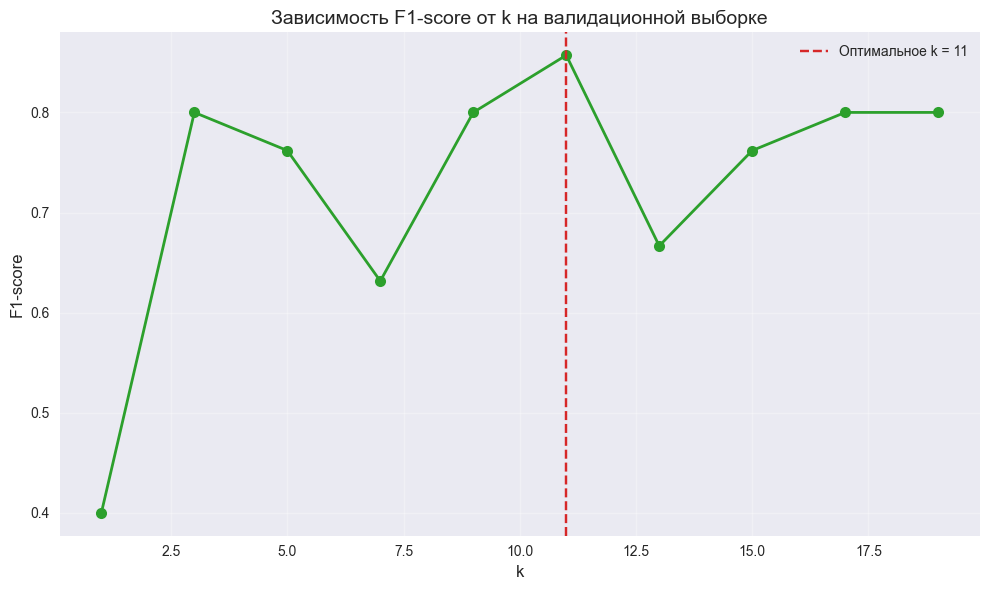


Оценка модели: KNN (k=11)
Accuracy:  0.3889
Precision: 0.4545
Recall:    0.5000
F1-score:  0.4762
ROC-AUC:   0.3375

Матрица ошибок:
              Предсказано
              0      1
Реально 0      2     6
        1      5     5


In [70]:
class KNNClassifier:
    """Классификатор k-ближайших соседей"""
    
    def __init__(self, k=5):
        self.k = k
        self.X_train = None
        self.y_train = None
    
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        return self
    
    def _euclidean_distance(self, x1, x2):
        """Евклидово расстояние"""
        return np.sqrt(np.sum((x1 - x2) ** 2))
    
    def predict_proba(self, X):
        """Предсказание вероятностей"""
        n_samples = len(X)
        probs = np.zeros(n_samples)
        
        for i in range(n_samples):
            distances = np.array([self._euclidean_distance(X[i], x) for x in self.X_train])
            
            k_indices = np.argsort(distances)[:self.k]
            k_nearest_labels = self.y_train[k_indices]
            
            probs[i] = np.mean(k_nearest_labels)
        
        prob_matrix = np.zeros((n_samples, 2))
        prob_matrix[:, 0] = 1 - probs
        prob_matrix[:, 1] = probs
        return prob_matrix
    
    def predict(self, X):
        """Предсказание классов"""
        probs = self.predict_proba(X)
        return (probs[:, 1] >= 0.5).astype(int)

print("Подбор оптимального k на валидационной выборке:")
print("-" * 65)

best_k = 1
best_f1 = 0
k_values = range(1, min(21, len(X_train) // 2), 2) 
k_scores = []

for k in k_values:
    knn = KNNClassifier(k=k)
    knn.fit(X_train_scaled, y_train)
    y_pred_knn_val = knn.predict(X_val_scaled)
    f1 = f1_score(y_val, y_pred_knn_val)
    k_scores.append(f1)
    
    if f1 > best_f1:
        best_f1 = f1
        best_k = k
    
    print(f"k = {k:2d}: F1-score = {f1:.4f}")

print(f"\nОптимальное k = {best_k} (F1-score = {best_f1:.4f})")

plt.figure(figsize=(10, 6))
plt.plot(k_values, k_scores, marker='o', linewidth=2, markersize=8, color='#2ca02c')
plt.axvline(x=best_k, color='#d62728', linestyle='--', label=f'Оптимальное k = {best_k}')
plt.xlabel('k', fontsize=12)
plt.ylabel('F1-score', fontsize=12)
plt.title('Зависимость F1-score от k на валидационной выборке', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

knn = KNNClassifier(k=best_k)
knn.fit(X_train_scaled, y_train)
y_pred_knn = knn.predict(X_test_scaled)
y_scores_knn = knn.predict_proba(X_test_scaled)[:, 1]

results_knn = evaluate_model(y_test, y_pred_knn, y_scores_knn, f"KNN (k={best_k})")


## 3 Логистическая регрессия

**Логистическая регрессия** — это линейный алгоритм классификации, который использует логистическую (сигмоидную) функцию для моделирования вероятности принадлежности к классу.

### Математическая основа:

**Логистическая функция (сигмоида):**
$$\sigma(z) = \frac{1}{1 + e^{-z}}$$

где $z = w_1x_1 + w_2x_2 + ... + w_nx_n + b$ — линейная комбинация признаков.

### Вероятность класса:

Вероятность принадлежности к классу 1:
$$P(y=1|X) = \sigma(w^T X + b) = \frac{1}{1 + e^{-(w^T X + b)}}$$

Вероятность принадлежности к классу 0:
$$P(y=0|X) = 1 - P(y=1|X) = \frac{e^{-(w^T X + b)}}{1 + e^{-(w^T X + b)}}$$

### Функция потерь:

Используется **логистическая функция потерь** (log loss, cross-entropy):
$$L = -\frac{1}{n}\sum_{i=1}^{n}[y_i \log(P(y_i=1|X_i)) + (1-y_i)\log(1-P(y_i=1|X_i))]$$

где $n$ — количество примеров.

### Градиентный спуск:

Для минимизации функции потерь используется **градиентный спуск**:

**Градиенты:**
$$\frac{\partial L}{\partial w_j} = \frac{1}{n}\sum_{i=1}^{n}(P(y_i=1|X_i) - y_i) \cdot x_{i,j}$$
$$\frac{\partial L}{\partial b} = \frac{1}{n}\sum_{i=1}^{n}(P(y_i=1|X_i) - y_i)$$

**Обновление параметров:**
$$w_j := w_j - \alpha \cdot \frac{\partial L}{\partial w_j}$$
$$b := b - \alpha \cdot \frac{\partial L}{\partial b}$$

где $\alpha$ — скорость обучения (learning rate).




Оптимальный порог: 0.5000 (F1-score = 0.9091)


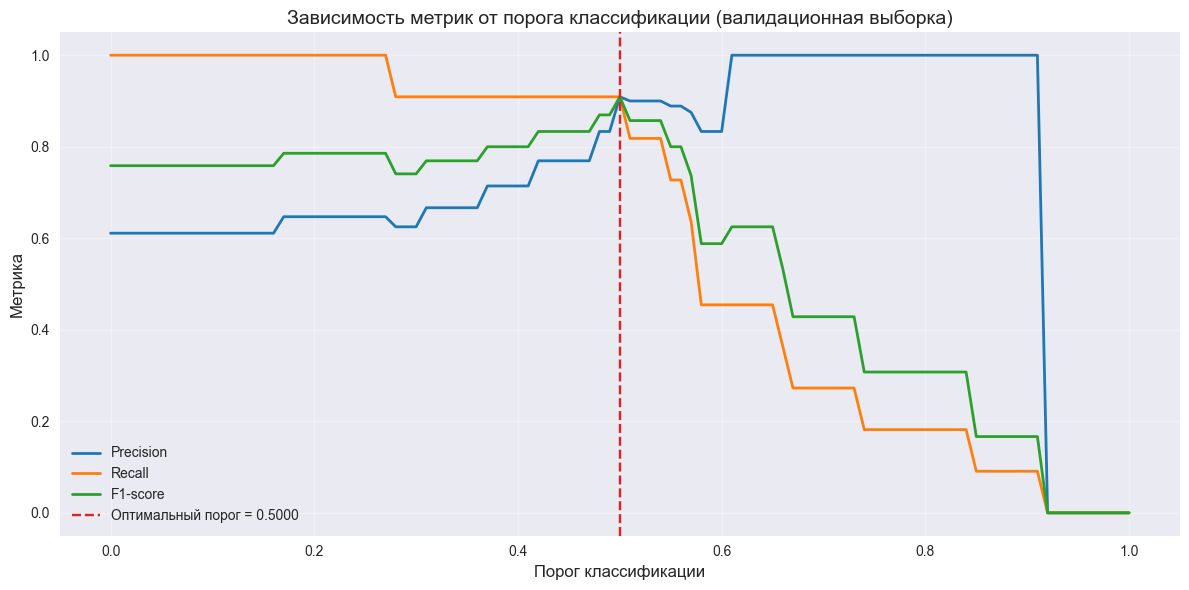


Оценка модели: Логистическая регрессия (порог=0.5000)
Accuracy:  0.6111
Precision: 0.6000
Recall:    0.9000
F1-score:  0.7200
ROC-AUC:   0.7625

Матрица ошибок:
              Предсказано
              0      1
Реально 0      2     6
        1      1     9


In [71]:
class LogisticRegression:
    """Логистическая регрессия с градиентным спуском"""
    
    def __init__(self, learning_rate=0.01, max_iter=1000, tol=1e-6):
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.tol = tol
        self.weights = None
        self.bias = None
    
    def _sigmoid(self, z):
        """Сигмоидная функция"""
        z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z))
    
    def fit(self, X, y):
        """Обучение модели"""
        n_samples, n_features = X.shape
        
        self.weights = np.zeros(n_features)
        self.bias = 0.0
      
        for i in range(self.max_iter):
     
            linear_model = np.dot(X, self.weights) + self.bias
            y_pred = self._sigmoid(linear_model)
         
            dw = (1 / n_samples) * np.dot(X.T, (y_pred - y))
            db = (1 / n_samples) * np.sum(y_pred - y)
        
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db
            
            if i > 0 and np.linalg.norm(dw) < self.tol:
                break
        
        return self
    
    def predict_proba(self, X):
        """Предсказание вероятностей"""
        linear_model = np.dot(X, self.weights) + self.bias
        prob_1 = self._sigmoid(linear_model)
        prob_0 = 1 - prob_1
        return np.column_stack([prob_0, prob_1])
    
    def predict(self, X, threshold=0.5):
        """Предсказание классов"""
        probs = self.predict_proba(X)[:, 1]
        return (probs >= threshold).astype(int)

lr = LogisticRegression(learning_rate=0.1, max_iter=2000)
lr.fit(X_train_scaled, y_train)

y_scores_lr_val = lr.predict_proba(X_val_scaled)[:, 1]


thresholds = np.linspace(0, 1, 101)
precisions = []
recalls = []
f1_scores = []

for threshold in thresholds:
    y_pred_thresh = (y_scores_lr_val >= threshold).astype(int)
    precisions.append(precision(y_val, y_pred_thresh))
    recalls.append(recall(y_val, y_pred_thresh))
    f1_scores.append(f1_score(y_val, y_pred_thresh))

best_threshold_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_idx]
best_f1_lr = f1_scores[best_threshold_idx]

print(f"Оптимальный порог: {best_threshold:.4f} (F1-score = {best_f1_lr:.4f})")


plt.figure(figsize=(12, 6))
plt.plot(thresholds, precisions, label='Precision', linewidth=2, color='#1f77b4')
plt.plot(thresholds, recalls, label='Recall', linewidth=2, color='#ff7f0e')
plt.plot(thresholds, f1_scores, label='F1-score', linewidth=2, color='#2ca02c')
plt.axvline(x=best_threshold, color='#d62728', linestyle='--', label=f'Оптимальный порог = {best_threshold:.4f}')
plt.xlabel('Порог классификации', fontsize=12)
plt.ylabel('Метрика', fontsize=12)
plt.title('Зависимость метрик от порога классификации (валидационная выборка)', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

y_pred_lr = lr.predict(X_test_scaled, threshold=best_threshold)
y_scores_lr = lr.predict_proba(X_test_scaled)[:, 1]

results_lr = evaluate_model(y_test, y_pred_lr, y_scores_lr, f"Логистическая регрессия (порог={best_threshold:.4f})")


АНАЛИЗ ВЕСОВ ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ

Свободный член (bias): 0.841625

ВЕСА ПРИЗНАКОВ (отсортированы по абсолютному значению)
        Признак       Вес    |Вес|
         retake -1.799035 1.799035
             ss -1.182887 1.182887
            age  1.089020 1.089020
         height  1.057391 1.057391
         social  0.985617 0.985617
work_experience  0.886047 0.886047
         hostel  0.771652 0.771652
     study_form  0.707656 0.707656
            sex -0.663929 0.663929
          sport  0.601999 0.601999
         stream -0.599433 0.599433
             os -0.575809 0.575809
          group -0.491032 0.491032
         cource  0.434496 0.434496
          score -0.403507 0.403507
      eye_color  0.392489 0.392489
        glasses  0.324752 0.324752
       interest -0.310349 0.310349
           miss  0.270722 0.270722
  weekend_study -0.214846 0.214846
     literature  0.199191 0.199191
      bad_sleep -0.192876 0.192876
      foot_size  0.048935 0.048935
             ai -0.020788 0.020788

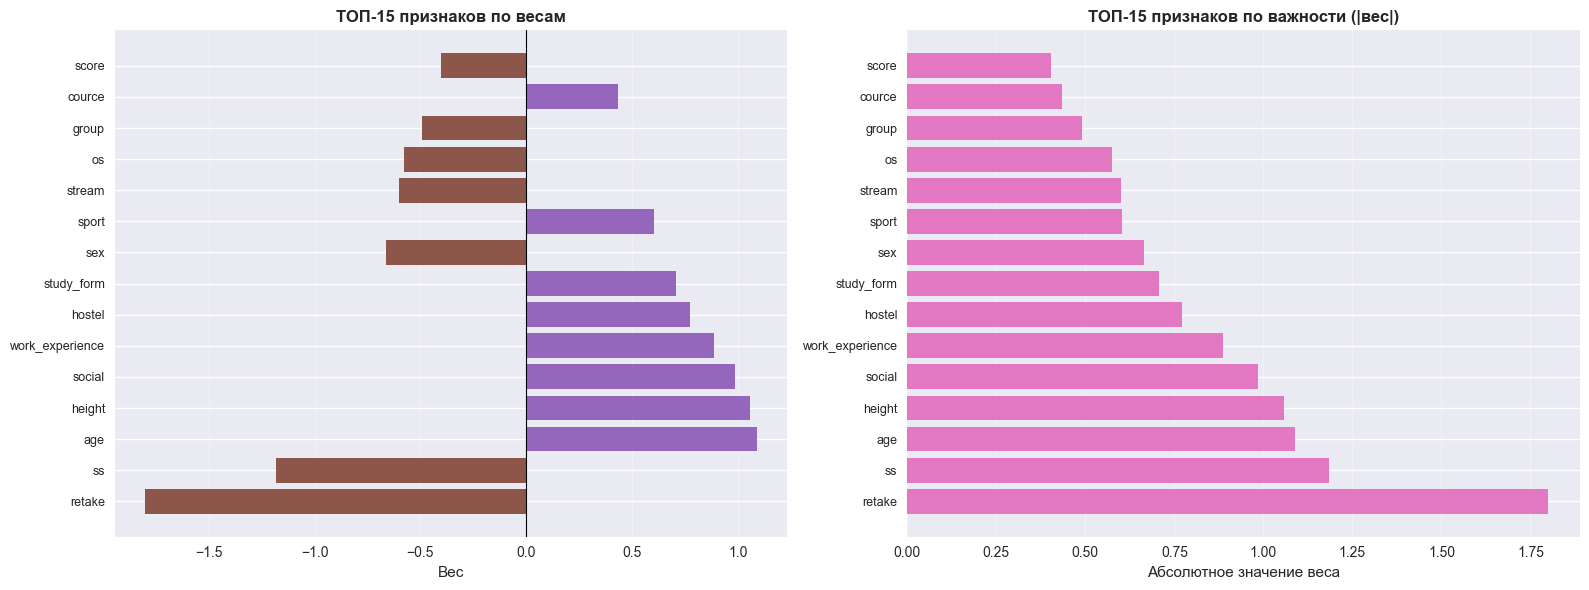

In [75]:
print("="*85)
print("АНАЛИЗ ВЕСОВ ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ")
print("="*85)

feature_names = X_processed.columns.tolist()
weights = lr.weights
bias = lr.bias

print(f"\nСвободный член (bias): {bias:.6f}")

weights_df = pd.DataFrame({
    'Признак': feature_names,
    'Вес': weights,
    '|Вес|': np.abs(weights)
})

weights_df = weights_df.sort_values('|Вес|', ascending=False)

print(f"\n{'='*85}")
print("ВЕСА ПРИЗНАКОВ (отсортированы по абсолютному значению)")
print(f"{'='*85}")
print(weights_df.to_string(index=False))

print(f"\n{'='*85}")
print("ТОП-10 ВАЖНЕЙШИХ ПРИЗНАКОВ")
print(f"{'='*85}")
top_features = weights_df.head(10)
for idx, row in top_features.iterrows():
    print(f"{row['Признак']:25s}: {row['Вес']:10.6f} (|{row['|Вес|']:.6f}|)")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

ax1 = axes[0]
top_15 = weights_df.head(15)
colors_bar = ['#9467bd' if w > 0 else '#8c564b' for w in top_15['Вес']]
ax1.barh(range(len(top_15)), top_15['Вес'], color=colors_bar)
ax1.set_yticks(range(len(top_15)))
ax1.set_yticklabels(top_15['Признак'], fontsize=9)
ax1.set_xlabel('Вес', fontsize=11)
ax1.set_title('ТОП-15 признаков по весам', fontsize=12, fontweight='bold')
ax1.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
ax1.grid(True, alpha=0.3, axis='x')

ax2 = axes[1]
ax2.barh(range(len(top_15)), top_15['|Вес|'], color='#e377c2')
ax2.set_yticks(range(len(top_15)))
ax2.set_yticklabels(top_15['Признак'], fontsize=9)
ax2.set_xlabel('Абсолютное значение веса', fontsize=11)
ax2.set_title('ТОП-15 признаков по важности (|вес|)', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()


## 4. Сравнение моделей



СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ (тестовая выборка)
                                Модель  Accuracy  Precision  Recall  F1-score  ROC-AUC
             Тривиальный классификатор  0.555556   0.555556     1.0  0.714286   0.5000
                         Наивный Байес  0.722222   0.727273     0.8  0.761905   0.7750
                            KNN (k=11)  0.388889   0.454545     0.5  0.476190   0.3375
Логистическая регрессия (порог=0.5000)  0.611111   0.600000     0.9  0.720000   0.7625


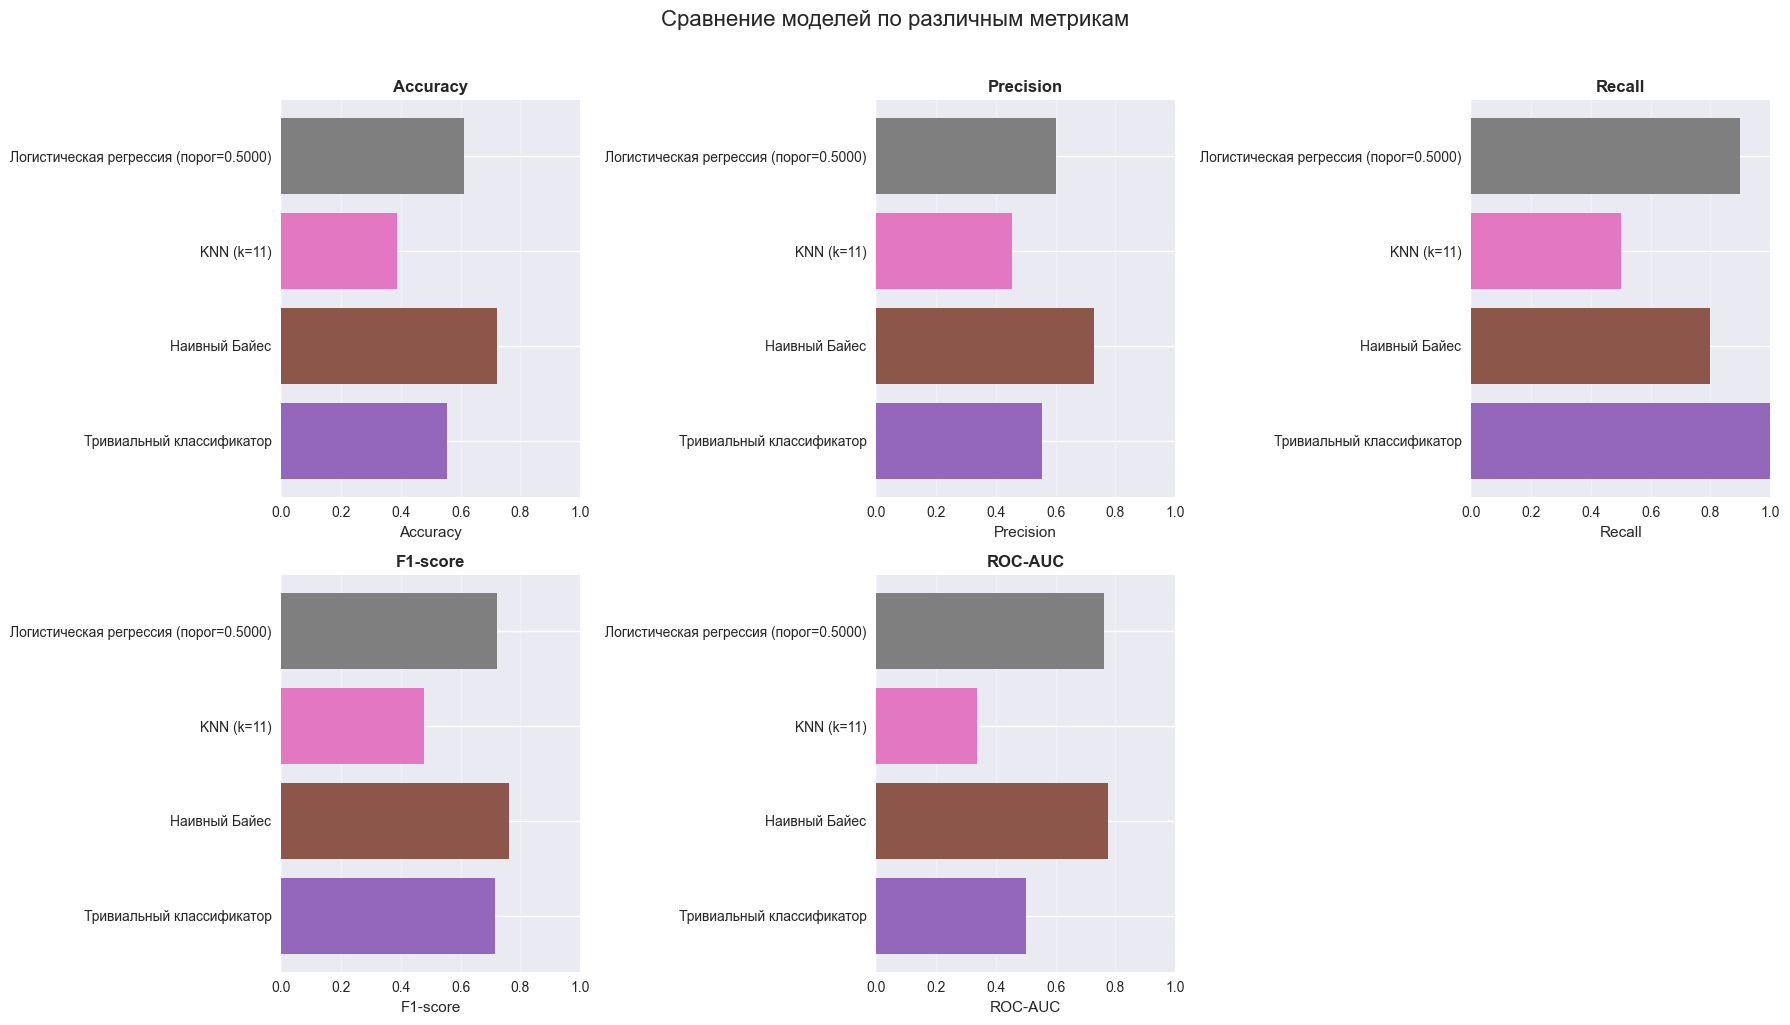

In [72]:
results_summary = pd.DataFrame({
    'Модель': ['Тривиальный классификатор', 'Наивный Байес', f'KNN (k={best_k})', 
               f'Логистическая регрессия (порог={best_threshold:.4f})'],
    'Accuracy': [results_trivial['accuracy'], results_nb['accuracy'], 
                 results_knn['accuracy'], results_lr['accuracy']],
    'Precision': [results_trivial['precision'], results_nb['precision'], 
                  results_knn['precision'], results_lr['precision']],
    'Recall': [results_trivial['recall'], results_nb['recall'], 
               results_knn['recall'], results_lr['recall']],
    'F1-score': [results_trivial['f1'], results_nb['f1'], 
                 results_knn['f1'], results_lr['f1']],
    'ROC-AUC': [roc_auc(y_test, y_scores_trivial), 
                roc_auc(y_test, y_scores_nb),
                roc_auc(y_test, y_scores_knn),
                roc_auc(y_test, y_scores_lr)]
})

print("\n" + "="*85)
print("СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ (тестовая выборка)")
print("="*85)
print(results_summary.to_string(index=False))

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Сравнение моделей по различным метрикам', fontsize=16, y=1.02)

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC-AUC']
models = results_summary['Модель'].values
colors = ['#9467bd', '#8c564b', '#e377c2', '#7f7f7f']

for idx, metric in enumerate(metrics):
    ax = axes[idx // 3, idx % 3]
    values = results_summary[metric].values
    bars = ax.barh(models, values, color=colors)
    ax.set_xlabel(metric, fontsize=11)
    ax.set_title(f'{metric}', fontsize=12, fontweight='bold')
    ax.set_xlim(0, 1)
    ax.grid(True, alpha=0.3, axis='x')
    


ax = axes[1, 2]
ax.axis('off')
ax.text(0.5, 0.5, '', ha='center', va='center', 
        fontsize=12, transform=ax.transAxes)

plt.tight_layout()
plt.show()


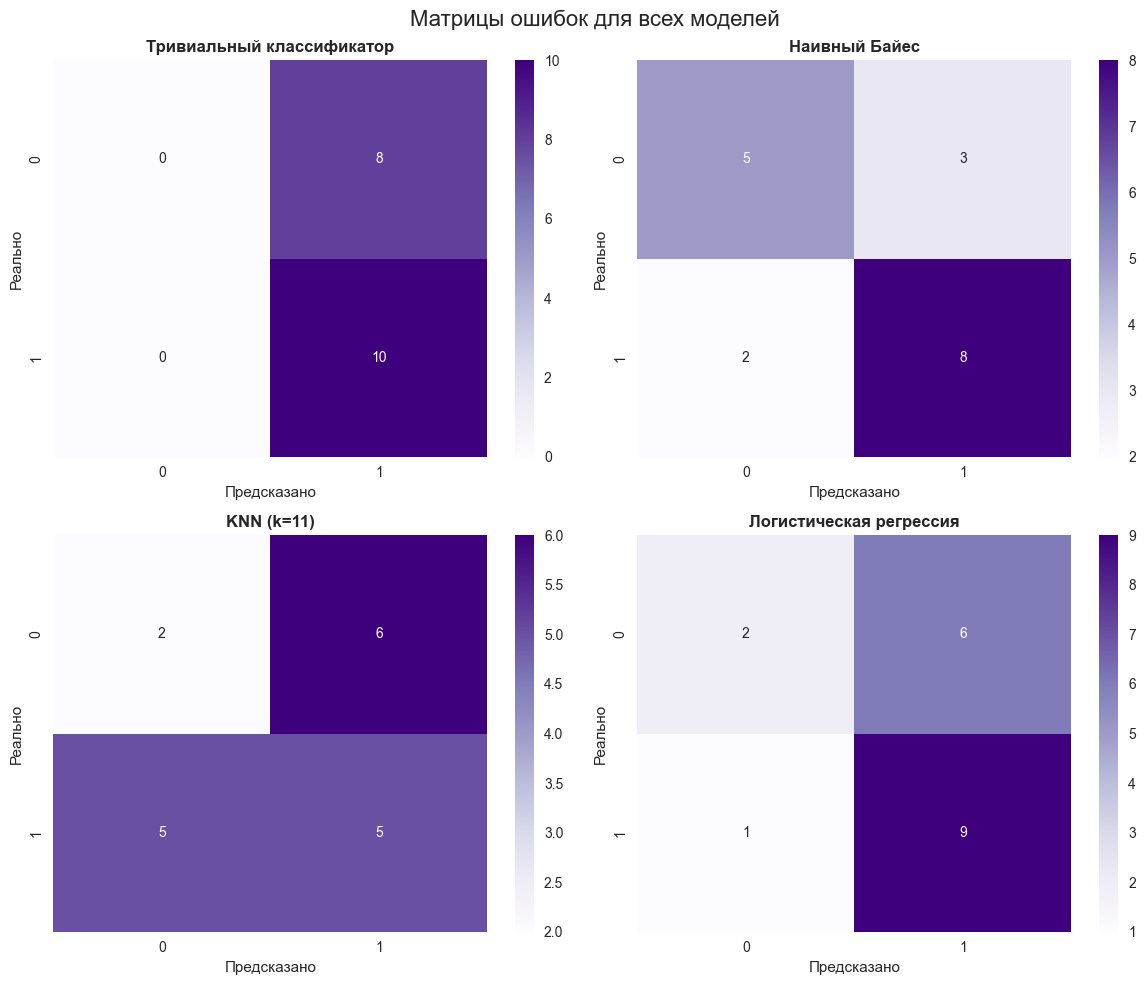

In [73]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Матрицы ошибок для всех моделей', fontsize=16)

models_data = [
    (results_trivial['confusion_matrix'], 'Тривиальный классификатор'),
    (results_nb['confusion_matrix'], 'Наивный Байес'),
    (results_knn['confusion_matrix'], f'KNN (k={best_k})'),
    (results_lr['confusion_matrix'], f'Логистическая регрессия')
]

for idx, (cm, title) in enumerate(models_data):
    ax = axes[idx // 2, idx % 2]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', ax=ax, 
                xticklabels=['0', '1'], yticklabels=['0', '1'])
    ax.set_xlabel('Предсказано', fontsize=11)
    ax.set_ylabel('Реально', fontsize=11)
    ax.set_title(title, fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

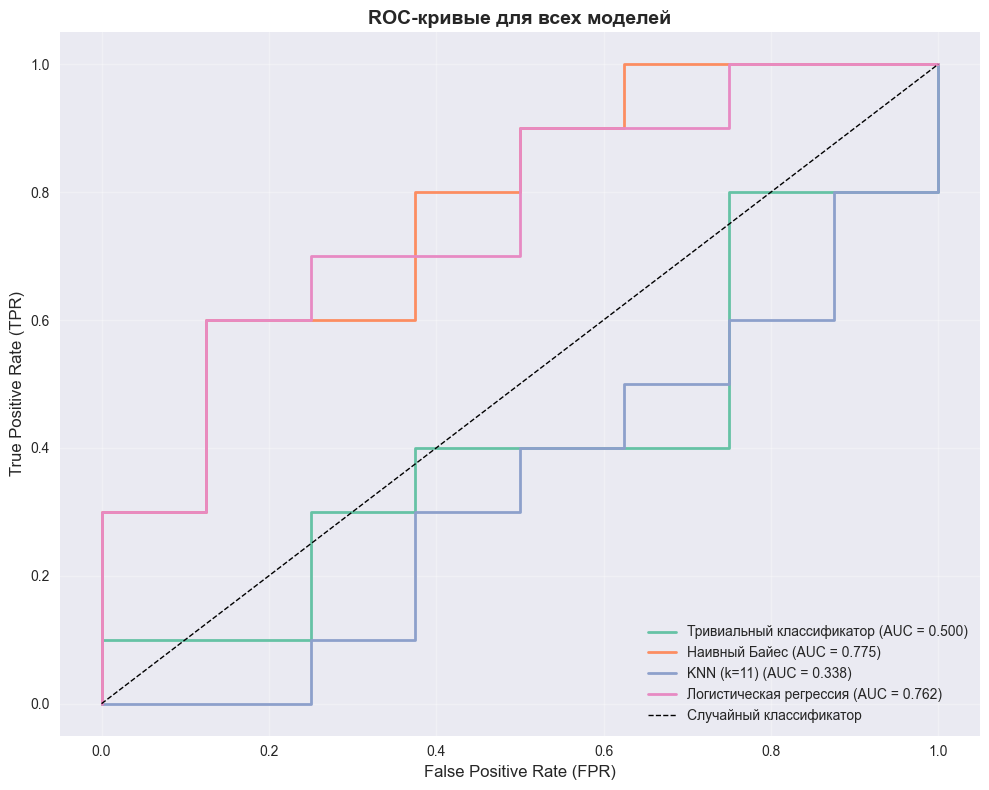

In [74]:
def plot_roc_curve(y_true, y_scores, label, ax):
    """Построение ROC-кривой"""
    sorted_indices = np.argsort(y_scores)[::-1]
    y_true_sorted = y_true[sorted_indices]
    y_scores_sorted = y_scores[sorted_indices]
    
    tpr = [0.0]
    fpr = [0.0]
    n_pos = np.sum(y_true == 1)
    n_neg = np.sum(y_true == 0)
    
    if n_pos == 0 or n_neg == 0:
        return
    
    tp = 0
    fp = 0
    
    for i in range(len(y_scores_sorted)):
        if y_true_sorted[i] == 1:
            tp += 1
        else:
            fp += 1
        
        tpr.append(tp / n_pos)
        fpr.append(fp / n_neg)
    
    auc = roc_auc(y_true, y_scores)
    ax.plot(fpr, tpr, label=f'{label} (AUC = {auc:.3f})', linewidth=2)

fig, ax = plt.subplots(figsize=(10, 8))
plot_roc_curve(y_test, y_scores_trivial, 'Тривиальный классификатор', ax)
plot_roc_curve(y_test, y_scores_nb, 'Наивный Байес', ax)
plot_roc_curve(y_test, y_scores_knn, f'KNN (k={best_k})', ax)
plot_roc_curve(y_test, y_scores_lr, 'Логистическая регрессия', ax)

ax.plot([0, 1], [0, 1], 'k--', label='Случайный классификатор', linewidth=1)
ax.set_xlabel('False Positive Rate (FPR)', fontsize=12)
ax.set_ylabel('True Positive Rate (TPR)', fontsize=12)
ax.set_title('ROC-кривые для всех моделей', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
